In [416]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./vehicle_palette.jpg')
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Hough transform

In [116]:
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180, 10, minLineLength,maxLineGap)

# cur_length = np.linalg.norm([a, b])

for l in lines:
    x1 = l[0][0]; y1 = l[0][1]; x2 = l[0][2]; y2 = l[0][3]
    
    cv2.line(histogram_norm_img,(x1,y1),(x2,y2),(255,0,0),2)

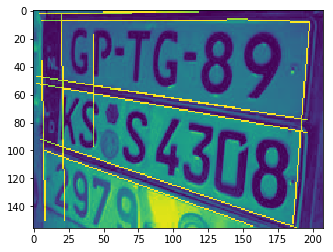

In [189]:
img = img_grayscale.copy()

# Apply Gaussian blur
kernel_size = 5
img_blured = cv2.GaussianBlur(img, (kernel_size, kernel_size),0)
_, img_thresholded = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_OTSU)

# Detect Canny threshold
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(img_blured, low_threshold, high_threshold)

# Perform Hough transform
rho = 0.75  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

line_image = np.copy(img_grayscale) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),1)
        
lines_edges = cv2.addWeighted(line_image, 0.8, img_grayscale, 1, 0)

plt.imshow(lines_edges)

### OpenCV Contours

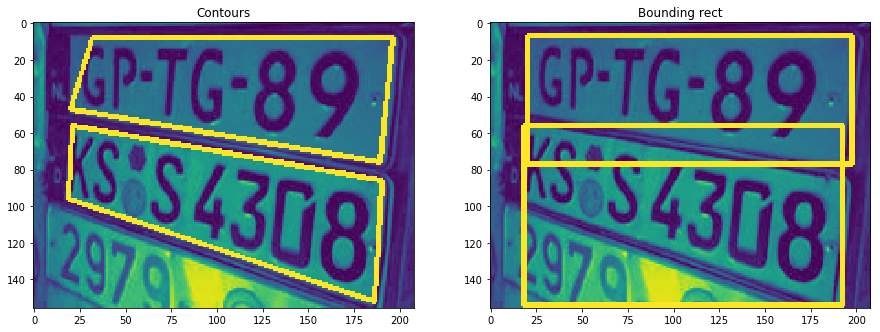

In [393]:
img = img_grayscale.copy()

# Apply Gaussian blur
kernel_size = 7
img_blured = cv2.GaussianBlur(img, (kernel_size, kernel_size),0)
# Threshold
_, img_thresholded = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_OTSU)
# Contours
contours, _ = cv2.findContours(img_thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

wth_conts = img_grayscale.copy()
wth_bboxes = img_grayscale.copy()

contours = sorted(contours, key=cv2.contourArea, reverse=True)

for cnt in contours[0:2]:
    approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
    if (len(approx) == 4):
        
        cv2.drawContours(wth_conts, [approx], 0, (255, 0 ,0), 2)

        x,y,w,h = cv2.boundingRect(cnt)
        bounding_rec = np.array([[x, y], [x + w, y],
                                [x, y + h], [x + w, y + h]], np.float32)        
        
        cv2.rectangle(wth_bboxes, (x, y), (x + w, y + h), (255, 0 ,0), 2)
        
        # approx = approx.reshape(bounding_rec.shape).astype(np.float32)
        # M = cv2.getPerspectiveTransform(approx, bounding_rec)
        # warp = cv2.warpPerspective(img, M, (w, h))
        
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.title('Contours')
plt.imshow(wth_conts)

fig.add_subplot(1, 2, 2)
plt.title('Bounding rect')
plt.imshow(wth_bboxes)

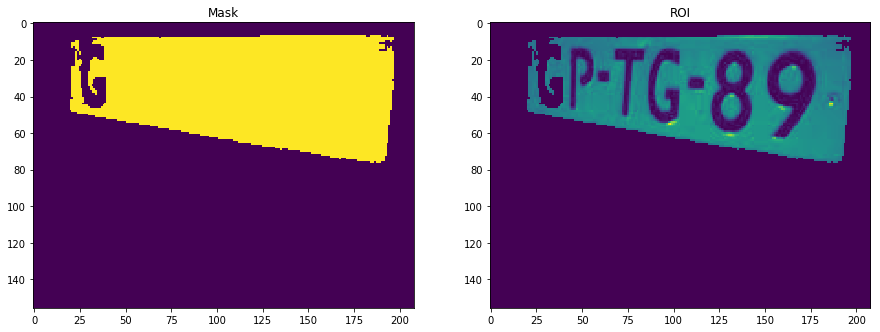

In [397]:
mask = np.zeros(img.shape, np.uint8)

mask = cv2.fillPoly(mask, pts=[contours[0]], color=(255,255,255))

masked_img = cv2.bitwise_and(mask, img)
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.title('Mask')
plt.imshow(mask)

fig.add_subplot(1, 2, 2)
plt.title('ROI')
plt.imshow(masked_img)

In [417]:
approx = cv2.approxPolyDP(contours[0], 0.04 * cv2.arcLength(cnt, True), True)
        
x,y,w,h = cv2.boundingRect(contours[0])
bounding_rec = np.array([[x, y], [x + w, y],
                         [x, y + h], [x + w, y + h]], np.float32)        

bounding_rec = order_points_new(bounding_rec)

approx = order_points_new(approx.reshape(4, 2))

In [418]:
def order_points_new(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # if use Euclidean distance, it will run in error when the object
    # is trapezoid. So we should use the same simple y-coordinates order method.

    # now, sort the right-most coordinates according to their
    # y-coordinates so we can grab the top-right and bottom-right
    # points, respectively
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

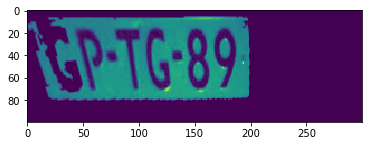

In [419]:
M = cv2.getPerspectiveTransform(approx, bounding_rec)
transformed = cv2.warpPerspective(masked_img, M, (300, 100))

plt.imshow(transformed)